## Rotate detailed morphology to align with y-axis in SWC format
This converting procedure works only for cells with a distal apical dendrite and a tuft.  

### Load original swc file

In [1]:
import pandas as pd
from utils.plotting.plot_morphology_swc import plot_morphology_swc
%matplotlib notebook

# read swc file
# swc_file = 'Rorb-IRES2-Cre-D_Ai14-212873.04.01.01_510987644_m.swc'
# model_name = 'neuronal_model_496930324'
# model_name = 'neuronal_model_497229089'
model_name = 'neuronal_model_491766131'
swc_file = model_name + '/' + 'reconstruction.swc'

swc0 = pd.read_csv(swc_file,sep=' ',skiprows=3,names='id,type,x,y,z,r,pid'.split(','),index_col='id')

# _ = plot_morphology_swc(swc0) # plot the original morphology

### Rotate the cell to align distal apical dendrite with y-axis

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn import linear_model

# function calculate rotation that moves source vector to target vector
def rotate_to_align(source,target):
    target = np.asarray(target)
    target = target/np.linalg.norm(target)
    source = np.asarray(source)
    source = source/np.linalg.norm(source)
    rotvec = np.cross(source,target)
    modulus = np.linalg.norm(rotvec)
    if modulus<1e-4:
        rot,_ = R.align_vectors(np.column_stack(target),np.column_stack(source)) # alternative method
    else:
        ang = np.sign(np.vdot(source,target))*(np.arcsin(modulus)-np.pi/2)+np.pi/2
        rot = R.from_rotvec(ang/modulus*rotvec)
    return rot

swc = swc0.copy() # to be written to new file
coor3d = list('xyz')

# children id
swc0['cid'] = [[] for _ in range(len(swc0))]
for i in swc0.index:
    pid = swc0.loc[i,'pid']
    if pid>0:
        swc0.loc[pid,'cid'].append(i)

# distance to soma
soma_id = swc0.index[swc0['type']==1][0] # soma index
soma = swc0.loc[soma_id,coor3d] # soma coordinates
centered_coord = (swc0[coor3d]-soma).astype('float64') # translate soma to the origin
swc0['dist'] = np.linalg.norm(centered_coord,axis=1) # distance to the soma

# find id of the segment of the first branch at distal apical dendrite and choose it as the end point
max_dist = np.max(swc0['dist'])
# search in segment further than half of the furthest segment distance
end_pt_id = swc0.index[((swc0['dist']>max_dist/2) & np.array([len(c)>1 for c in swc0['cid']]) & (swc0['type']==4)).tolist().index(True)]

# rotate the cell to make apical dendrite align with y-axis and write to a new dataframe
cell_orien = np.array([0.,1.,0.]) # target orientation (rotate to align with y-axis)
orien = centered_coord.loc[end_pt_id] # end point orientation
rot2y = rotate_to_align(orien,cell_orien)
swc[coor3d] = rot2y.apply(centered_coord)

# rotate about y axis to put basal dendrites around xy-plane
basal = swc.index[swc['type']==3]
lreg = linear_model.LinearRegression(fit_intercept=False)
lreg.fit(swc.loc[basal,'x'].values.reshape(-1,1),swc.loc[basal,'z'].values.reshape(-1,1))
rot_y = R.from_euler('y',np.arctan(lreg.coef_[0,0]))
swc[coor3d] = rot_y.apply(swc[coor3d])

# The rotation representations below can be read by BMTK
rot = rot_y*rot2y # compose two rotations
print(rot.apply(orien)) # check final end point position after rotation (should be close to [0,y,0])
rot_zyx = rot.as_euler('zyx') # rotation angles around z then y then x 
# quaternion = rot.as_quat() # quaternion representation of rotation

[ 1.06276099e-13  5.06243483e+02 -2.13162821e-14]


### Save rotated swc file

In [3]:
# save rotated swc file
try:
    rot_file = 'sim_details/components/morphologies/' + model_name + '_rotate.swc'
except:
    rot_file = 'sim_details/components/morphologies/' + swc_file[:swc_file.find('.swc')] + '_rotate.swc'
        
with open(swc_file,'r') as f:
    lines = [next(f) for i in range(3)]

with open(rot_file,'w') as f:
    for line in lines:
        f.write(line)
swc.to_csv(rot_file,sep=' ',header=False,float_format='%.4f',mode='a')

### Plot rotated morphology
Start with the cell below if the swc file of rotated cell is created in previous step.

In [3]:
import numpy as np
import pandas as pd

# read rotated morphology file
rot_file = 'sim_details/components/morphologies/' + model_name + '_rotate.swc'
swc = pd.read_csv(rot_file,sep=' ',skiprows=3,names='id,type,x,y,z,r,pid'.split(','),index_col='id')

In [4]:
# children id
swc['cid'] = [[] for _ in range(len(swc))]
for i in swc.index:
    pid = swc.loc[i,'pid']
    if pid>0:
        swc.loc[pid,'cid'].append(i)

# distance to soma
coor3d = list('xyz')
soma_id = swc.index[swc['type']==1][0] # soma index
soma = swc.loc[soma_id,coor3d] # soma coordinates
swc['dist'] = np.linalg.norm((swc[coor3d]-soma).astype(float),axis=1)

# find id of the segment of the first branch at distal apical dendrite and choose it as the end point
max_dist = np.max(swc['dist'])
# search in segment further than half of the furthest segment distance
end_pt_id = swc.index[((swc['dist']>max_dist/2) & np.array([len(c)>1 for c in swc['cid']]) & (swc['type']==4)).tolist().index(True)]

# calculate length of each segment
swc['L'] = np.zeros((len(swc),1))
nonsoma = swc['type'].values>1
swc.loc[swc.index[nonsoma],'L'] = np.linalg.norm(swc.loc[nonsoma,coor3d].values-swc.loc[swc[nonsoma]['pid'],coor3d].values,axis=1)

In [5]:
# calculate path length from soma of each segment
swc['L_path'] = np.zeros((len(swc),1))
def add_path_length(df,pid):
    for cid in df.loc[pid,'cid']:
        df.loc[cid,'L_path'] = df.loc[pid,'L_path'] + df.loc[cid,'L']
        add_path_length(df,cid)
add_path_length(swc,1)

In [6]:
# function find all chidren given a root segment id
def all_children(df,pid,cids=None):
    if cids is None:
        cids = np.zeros(len(df),dtype=bool)
    for cid in df.loc[pid,'cid']:
        cids[df.index.get_loc(cid)] = True
        all_children(df,cid,cids=cids)
    return cids

# function find all parents till soma given a segment id
def all_parents(df,cid):
    pids = np.zeros(len(df),dtype=bool)
    pid = df.loc[cid,'pid']
    p0id = df.loc[pid,'pid']
    while p0id>0:
        pids[df.index.get_loc(cid)] = True
        cid = pid
        pid = p0id
        p0id = df.loc[p0id,'pid']
    return pids

In [7]:
# find the sections
axon = np.asarray(swc['type']==2)
basal = np.asarray(swc['type']==3)
tuft = all_children(swc,end_pt_id) # bool array
trunk = all_parents(swc,end_pt_id)
apical = np.asarray((swc['type']==4) & (~tuft) & (~trunk))

names = ['axon','basal','apical','trunk','tuft']
sec_idx = [axon,basal,apical,trunk,tuft]
colors = ['r','b','c','m','purple']

<IPython.core.display.Javascript object>


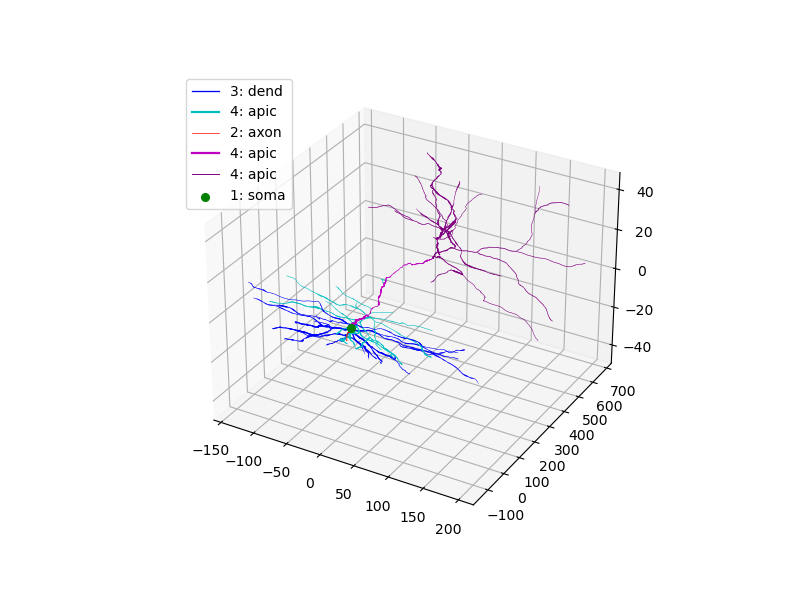

In [8]:
# plot tuft
%matplotlib notebook
fig,ax = plot_morphology_swc(swc,child_idx=~(tuft|trunk))
_ = plot_morphology_swc(swc,child_idx=trunk,root_id=soma_id,ax=ax,clr=['g']+colors[:2]+[colors[3]]) 
_ = plot_morphology_swc(swc,child_idx=tuft,root_id=end_pt_id,ax=ax,clr=['g']+colors[:2]+[colors[4]])

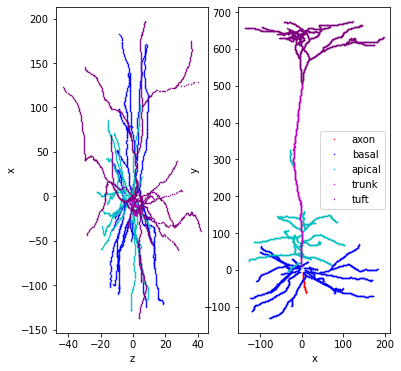

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))

plt.subplot(121)
for idx,name,clr in zip(sec_idx,names,colors):
    plt.plot(swc.loc[idx,'z'],swc.loc[idx,'x'],'.',color=clr,label=name,markersize=1)
plt.xlabel('z')
plt.ylabel('x')

plt.subplot(122)
for idx,name,clr in zip(sec_idx,names,colors):
    plt.plot(swc.loc[idx,'x'],swc.loc[idx,'y'],'.',color=clr,label=name,markersize=1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.show()

### Get geometry properties

In [11]:
# section properties: idx-index in swc, r,c-reach,center in 3d, axial-single branch along axial,
# L-length of each branch, R-radius, ang-elevation angle of branch, L_scale-Length scaling factor
sec_prop = pd.DataFrame(np.zeros((5,4)),columns=['L','R','ang','L_scale'])
sec_prop.insert(0,'name',names)
sec_prop.insert(1,'axial',np.array([1,0,0,1,0]).astype(bool))
sec_prop.insert(len(sec_prop.columns),'idx',sec_idx)
sec_prop.insert(len(sec_prop.columns)-1,'c',[np.zeros(3) for _ in range(len(sec_prop))])
sec_prop.insert(len(sec_prop.columns)-2,'r',[np.zeros(3) for _ in range(len(sec_prop))])

In [12]:
# reach of dendrite sections and center coordinate along each axis in 3d
def reach(swc,idx):
    r = []
    c = []
    for i,x in enumerate(list('xyz')):
        Max = swc.loc[idx,x].max()
        Min = swc.loc[idx,x].min()
        r.append((Max-Min)/2)
        c.append((Max+Min)/2)
    return r, c

ndcm = 3 # decimal number
for _,sec in sec_prop.iterrows():
    sec['r'][:], sec['c'][:] = np.around(reach(swc,sec['idx']),ndcm)

In [13]:
# geometry of sections
idx = sec_prop.index[sec_prop['name']=='axon'][0]
sec_prop.loc[idx,'ang'] = -np.pi/2
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][1]-sec_prop.loc[idx,'c'][1]

idx = sec_prop.index[sec_prop['name']=='basal'][0]
sec_prop.loc[idx,'ang'] = np.arctan((sec_prop.loc[idx,'c'][1]-sec_prop.loc[idx,'r'][1])/sec_prop.loc[idx,'r'][0])
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][0]/np.cos(sec_prop.loc[idx,'ang'])

idx = sec_prop.index[sec_prop['name']=='apical'][0]
sec_prop.loc[idx,'ang'] = 0.
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][0]

idx = sec_prop.index[sec_prop['name']=='trunk'][0]
sec_prop.loc[idx,'ang'] = np.pi/2
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'c'][1]+sec_prop.loc[idx,'r'][1]

idx = sec_prop.index[sec_prop['name']=='tuft'][0]
sec_prop.loc[idx,'ang'] = np.arctan(2*sec_prop.loc[idx,'r'][1]/sec_prop.loc[idx,'r'][0])
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][0]/np.cos(sec_prop.loc[idx,'ang'])

sec_prop['L'] = np.around(sec_prop['L'],ndcm)

In [14]:
# average radius of each type: direct average, average at root segment, 
# consistent membrane area, consistent axial resistance, consistant length constant
radius = lambda swc,idx: [
    swc.loc[idx,'r'].mean(),
    swc.loc[find_roots(swc,idx),'r'].mean(),
    np.dot(swc.loc[idx,'r'],swc.loc[idx,'L'])/np.sum(swc.loc[idx,'L']),
    (np.sum(swc.loc[idx,'L'])/np.dot(swc.loc[idx,'r']**(-2),swc.loc[idx,'L']))**.5,
    (np.sum(swc.loc[idx,'L'])/np.dot(swc.loc[idx,'r']**(-.5),swc.loc[idx,'L']))**2
]
def find_roots(swc,idx):
    swc_idx = pd.DataFrame(idx,index=swc.index,columns=['i'])
    roots = [i for i in swc.index[idx] if not swc_idx.loc[swc.loc[i,'pid'],'i']]
    return roots

avg_r = []
for i,sec in sec_prop.iterrows():
    r = radius(swc,sec['idx'])
    avg_r.append(r)
    if sec['axial']:
        r[-1] *= (sec['L']/np.sum(swc.loc[sec['idx'],'L']))**.5
    r = np.around(r,ndcm)
    sec_prop.loc[i,'R'] = r[-1]

avg_r = pd.DataFrame(np.array(avg_r),
                     columns = [
                         'direct average',
                         'average at root segment',
                         'consistent membrane area',
                         'consistent axial resistance',
                         'consistant length constant'
                     ])
avg_r.insert(0,'name',sec_prop['name'])
display(avg_r)

# Length scaling factor to maintain total membrane area
for i,sec in sec_prop.iterrows():
    sec_prop.loc[i,'L_scale'] = np.around(np.dot(swc.loc[sec['idx'],'r'],swc.loc[sec['idx'],'L'])/(sec['R']*sec['L']),ndcm)

display(sec_prop)

,name,direct average,average at root segment,consistent membrane area,consistent axial resistance,consistant length constant
0,axon,0.188206,0.228800,0.191699,0.174305,0.179896
1,basal,0.243029,0.358925,0.245864,0.197200,0.218222
2,apical,0.216200,0.228800,0.218932,0.181571,0.197475
3,trunk,0.269794,0.743600,0.275406,0.200495,0.228297
4,tuft,0.212531,0.216500,0.212297,0.181795,0.193875


,name,axial,L,R,ang,L_scale,r,c,idx
0,axon,True,62.513,0.180,-1.570796,1.092,"[3.681, 28.1, 0.644]","[5.704, -34.413, -0.279]","[False, False, False, False, False, False, Fal..."
1,basal,False,201.849,0.218,-0.706046,10.854,"[153.594, 100.228, 16.534]","[29.272, -30.738, 2.206]","[False, True, True, True, True, True, True, Tr..."
2,apical,False,115.144,0.197,0.000000,11.976,"[115.144, 165.726, 16.292]","[-12.862, 160.785, -5.938]","[False, False, False, False, False, False, Fal..."
3,trunk,True,506.243,0.228,1.570796,1.219,"[10.836, 248.351, 2.991]","[-10.089, 257.892, 0.631]","[False, False, False, False, False, False, Fal..."
4,tuft,False,236.302,0.194,0.787598,8.620,"[166.723, 83.729, 42.87]","[29.973, 590.873, -0.724]","[False, False, False, False, False, False, Fal..."


Soma radius: 6.9553 um


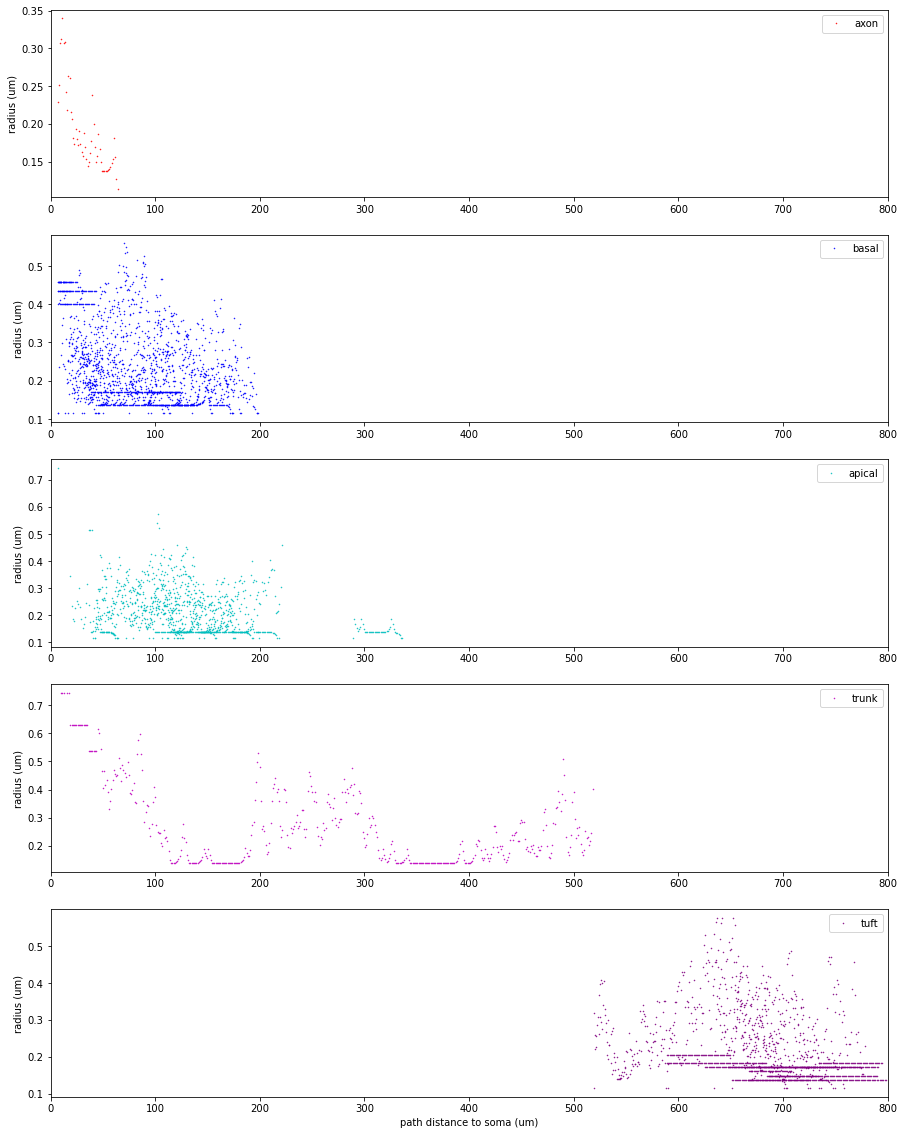

In [15]:
# plot radius distribution
print('Soma radius: {} um'.format(swc.loc[1,'r']))

max_path = np.around(swc['L_path'].max(),-1)
nsec = len(sec_idx)
plt.figure(figsize=(15,4*nsec))
for i in range(nsec):
    plt.subplot(nsec,1,i+1)
    plt.plot(swc.loc[sec_idx[i],'L_path'],swc.loc[sec_idx[i],'r'],'.',color=colors[i],label=names[i],markersize=1)
    plt.legend(loc=1)
    plt.ylabel('radius (um)')
    plt.xlim([0,max_path])
plt.xlabel('path distance to soma (um)')
plt.show()